In [ ]:
cd /home/schlecker/repos/planeteScripts

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

import output
import plots
import stats
import utils

%load_ext autoreload
%autoreload 2

# default output folder
# outputs = '/home/schlecker/phd/planete/outputs/pop06_MstarGrid/'
outputs = '/media/martin/Daten/phd/planete/outputs/pop06_MstarGrid/'

pd.set_option('display.max_columns', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read ref_reds into a list of populations

In [ ]:
filenames = ['ref_red5e9_0.3Msol.dat', 'ref_red5e9_0.5Msol.dat', 'ref_red5e9_0.7Msol.dat', 'ref_red5e9_1.0Msol.dat'] 
populations = [output.Population(outputs + f, name=f[11:18]) for f in filenames]

In [ ]:
pops = output.Population([outputs + f for f in filenames])

concatenate population data into a single multiindex-dataframe

In [ ]:
jointdf = pd.concat([pop.data for pop in populations], axis=0, keys=[pop.name for pop in populations])

not yet sure what to do with this... lets get some stats

In [ ]:
stats = {p.name : p.get_typeStats() for p in populations}

In [ ]:
stats['0.5Msol']

In [ ]:
for planetType in stats['0.5Msol']:
    print(planetType)

how about a summary plot?

In [ ]:
def plot_typeStats(populations):
    """
    
    """
    if isinstance(populations, list):
        stats = {p.name : p.get_typeStats() for p in populations}
        fig, ax = plt.subplots()
        stellarMasses = [0.3, 0.5, 0.7, 1.0]
        for M, Mstar in enumerate(stats.keys()):
            for planetType in stats[Mstar]:
                plt.errorbar(stellarMasses[M], stats[Mstar][planetType]['meanMetallicity'], stats[Mstar][planetType]['stdMetallicity'],
                             capsize=40., fmt='o', label=planetType)
        plt.legend()

In [ ]:
plot_typeStats(populations)

wow, this was rough. let's try something else

In [ ]:
for Mstar, MPop in jointdf.groupby(level=0):

In [ ]:
sns.catplot(x='Mstar', y='Metallicity', kind='bar', data=jointdf)

## disk lifetime analysis

In [50]:
tDiskFiles = [outputs + s for s in ['ref_redtdisk_0.3Msol.dat','ref_redtdisk_0.5Msol.dat', 'ref_redtdisk_0.7Msol.dat', 'ref_redtdisk_1.0Msol.dat']]

In [52]:
Mgrid = output.Population()
Mgrid.read_tDiskData(tDiskFiles)

compute disk fractions and store them separately for each Mstar

In [260]:
diskFractions = {Mstar : utils.get_diskFractions(tDiskData, Ntimes=50) for Mstar, tDiskData in Mgrid.tDiskData.groupby(level=0)}

In [114]:
group = Mgrid.tDiskData.groupby(level=0)
tDiskData03 = group.get_group('0.3Msol')
tDiskData03.t.describe()

count    9.988000e+03
mean     8.929732e+06
std      4.701408e+06
min      1.298540e+06
25%      5.220575e+06
50%      7.918750e+06
75%      1.172385e+07
max      3.102870e+07
Name: t, dtype: float64

fit exponential function to disk fractions

In [220]:
def exponential(x, dx, tau):
    return np.exp(-(x+dx)/tau)

In [237]:
def fit_diskFractions(times, fractions):
    params, covariance = curve_fit(exponential, times, fractions, bounds=([-np.inf, 5e3], [np.inf, 3e7]))
#     params_std = np.sqrt(np.diag(covariance))
#     print(params)
#     print(covariance)
#     print('std of parameter errors: {}'.format(params_std))
    
    return params, covariance

In [268]:
def get_fitRangeMask(fractions, f0=0.8, f1=0.01):
    """create mask to constrain range for the fit."""
    return np.ma.masked_inside(fractions, f0, f1)

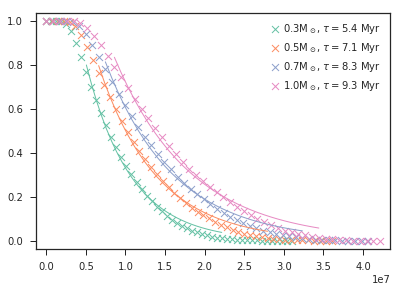

In [278]:
fig, ax = plt.subplots()

tau = []
for Mstar, fractions in diskFractions.items():
    
    # mask times and fit exponential function
    fitRangeMask = get_fitRangeMask(fractions[1])
    fitParams = fit_diskFractions(fractions[0][fitRangeMask.mask], fractions[1][fitRangeMask.mask])
    diskFractions[Mstar] += fitParams
    tau.append(fitParams[0][1])
    
    # plot fractions
    ax.scatter(fractions[0], fractions[1], marker='x', label=Mstar[:-4] + r'$\mathrm{M_\odot}$' + r', $\tau = {:1.1f}$ Myr'.format(tau[-1]/1e6))
    
    # plot fits
    ax.plot(fractions[0][fitRangeMask.mask], exponential(fractions[0][fitRangeMask.mask], diskFractions[Mstar][2][0], diskFractions[Mstar][2][1]))
    
plt.legend()
plt.show()

To parametrize the fraction of remaining disks, we apply a simple exponential fit of the form f(t) = exp(-(x+dx)/tau), where dx is a temporal offset and tau represents the time at which the fraction of systems with disks decreased to 1/e. There is a clear trend of increasing disk lifetimes with increasing stellar mass. 

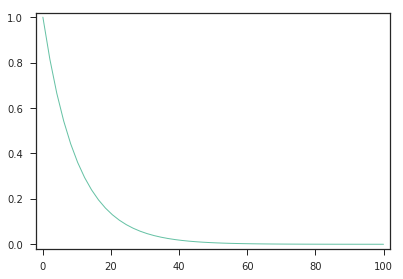

In [256]:
x = np.linspace(0., 100)
plt.plot(x, exponential(x, 0, 10))
plt.show()

In [259]:
exponential(11., 0, 11.)

0.36787944117144233

In [258]:
1/np.e

0.36787944117144233